In [53]:
import pandas as pd
import numpy as np
import snsynth as sn
import seaborn as sns
from snsynth.mst import MSTSynthesizer
import matplotlib.pyplot as plt

In [54]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
         'marital-status', 'occupation', 'relationship', 'race',
         'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
         'native-country', 'income']

adult = pd.read_csv('adult.data', sep=',\s+', header=None, names=names, na_values='?', engine='python', skipinitialspace=True)

adult.dropna(inplace=True)

adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [55]:
adult_q1 = adult.drop(columns=['fnlwgt', 'occupation', 'education-num', 'capital-gain', 'capital-loss', 'age', 'education', 'race', 'marital-status', 'relationship', 'native-country', 'income', 'workclass'])

In [56]:
synth_1 = sn.Synthesizer.create('mst', epsilon=1.0, verbose=True)
synth_1.fit(adult_q1)

Fitting with 188 dimensions
Getting cliques
Estimating marginals


In [57]:
synth_100 = sn.Synthesizer.create('mst', epsilon=100, delta=1e-05, verbose=True)
synth_100.fit(adult_q1)

Fitting with 188 dimensions
Getting cliques
Estimating marginals


In [58]:
synth_1.sample(100)

,gender,hours-per-week
0,Female,10
1,Male,40
2,Male,40
3,Male,40
4,Male,60
...,...,...
95,Male,45
96,Male,35
97,Male,40
98,Female,25


In [59]:
synth_100.sample(10)

,gender,hours-per-week
0,Female,50
1,Male,40
2,Female,37
3,Female,40
4,Male,60
5,Male,40
6,Female,30
7,Female,40
8,Male,70
9,Male,40


In [40]:
marital_status_distribution = adult['hours-per-week'].value_counts()
print(marital_status_distribution)

hours-per-week
40    14251
50     2718
45     1753
60     1405
35     1184
      ...  
82        1
94        1
92        1
87        1
74        1
Name: count, Length: 94, dtype: int64


## Question: Do men and women work a different amount of hours per week ?

Real values:

In [60]:
mean_hours_per_week_by_gender = adult.groupby('gender')['hours-per-week'].mean()
print(mean_hours_per_week_by_gender)

gender
Female    36.932222
Male      42.850687
Name: hours-per-week, dtype: float64


Differentially-private values:

In [61]:
num_samples = 100
sampled_means = []

for _ in range(num_samples):
    sampled = synth_1.sample(10000)
    mean_hours = sampled.groupby('gender')['hours-per-week'].mean()
    sampled_means.append(mean_hours)

sampled_means_df = pd.DataFrame(sampled_means)

mean_hours_per_week_by_gender_sampled_1 = sampled_means_df.mean()
print(mean_hours_per_week_by_gender_sampled_1)

gender
Female    37.479550
Male      42.793256
dtype: float64


In [76]:
print(sampled_means_df.std())

gender
Female    0.081282
Male      0.051144
dtype: float64


In [62]:
sampled_means_100 = []

for _ in range(num_samples):
    sampled_100 = synth_100.sample(10000)
    mean_hours = sampled_100.groupby('gender')['hours-per-week'].mean()
    sampled_means_100.append(mean_hours)

sampled_means_100_df = pd.DataFrame(sampled_means_100)

mean_hours_per_week_by_gender_sampled_100 = sampled_means_100_df.mean()
print(mean_hours_per_week_by_gender_sampled_100)

gender
Female    36.969819
Male      42.850209
dtype: float64


In [77]:
print(sampled_means_100_df.std())

gender
Female    0.035040
Male      0.019193
dtype: float64


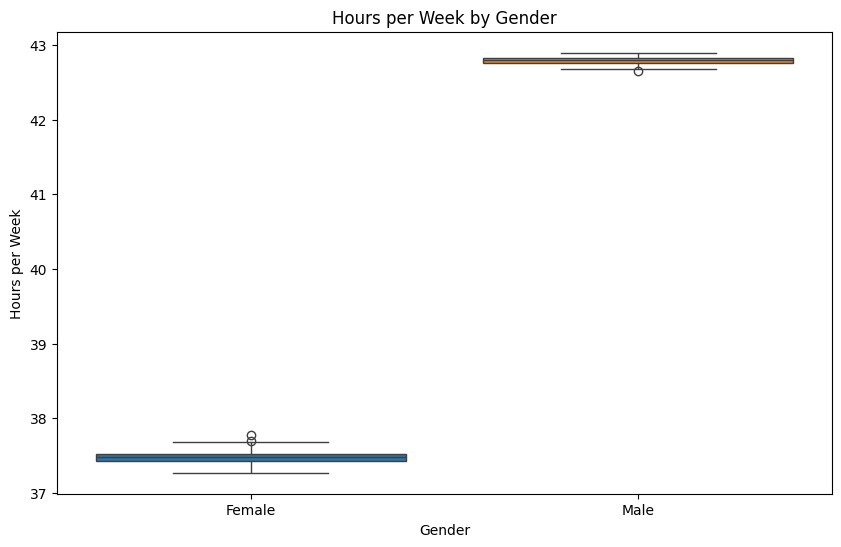

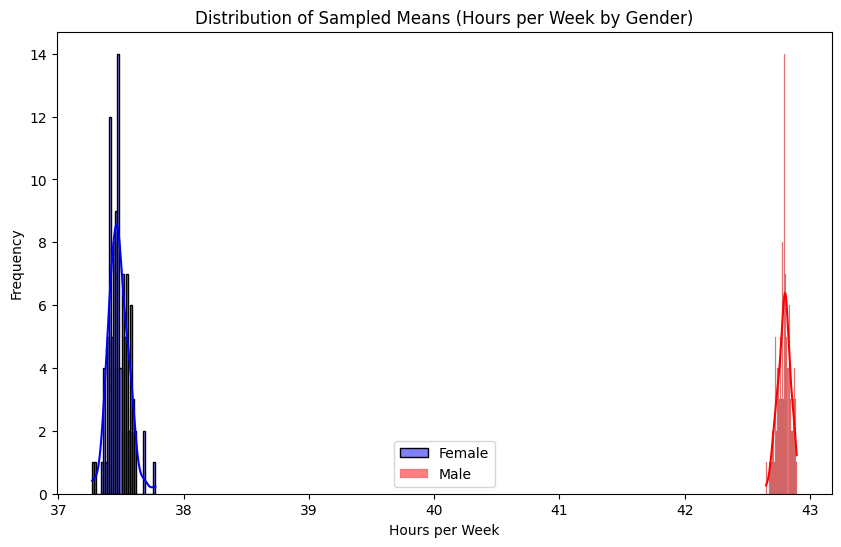

In [66]:
mean_std_df = sampled_means_df.agg(['mean', 'std'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=sampled_means_df)
plt.title('Hours per Week by Gender')
plt.xlabel('Gender')
plt.ylabel('Hours per Week')
plt.savefig('e1_eps1.pdf')

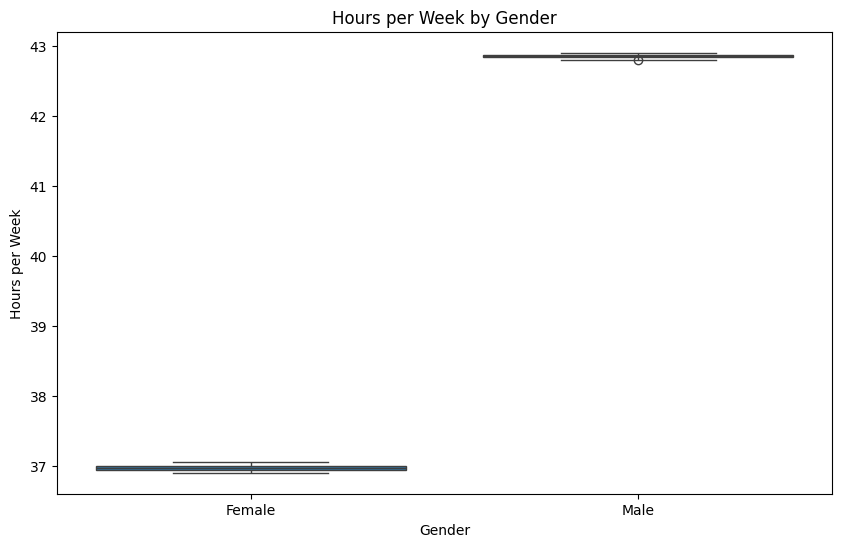

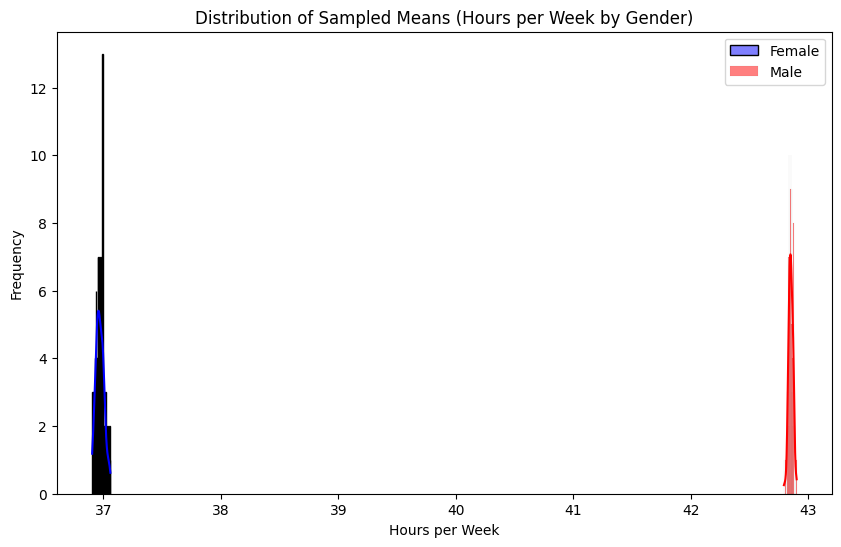

In [65]:
mean_std_df = sampled_means_100_df.agg(['mean', 'std'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=sampled_means_100_df)
plt.title('Hours per Week by Gender') 
plt.xlabel('Gender')
plt.ylabel('Hours per Week')
plt.savefig('e1_eps100.pdf')

# Plot the distribution of the sampled means
plt.figure(figsize=(10, 6))
sns.histplot(sampled_means
plt.xlim(41, 43)_100_df['Female'], kde=True, label='Female', color='blue', bins=30)
sns.histplot(sampled_means_100_df['Male'], kde=True, label='Male', color='red', bins=30)
plt.title('Distribution of Sampled Means (Hours per Week by Gender)')
plt.xlabel('Hours per Week')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('distribution_eps100.pdf')
plt.show()

In [75]:
def euclidean_distance(x1, x2, y1, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

x1, y1 = mean_hours_per_week_by_gender['Female'], mean_hours_per_week_by_gender['Male']
x2, y2 = mean_hours_per_week_by_gender_sampled_1['Female'], mean_hours_per_week_by_gender_sampled_1['Male']
x3, y3 = mean_hours_per_week_by_gender_sampled_100['Female'], mean_hours_per_week_by_gender_sampled_100['Male']

print("epsilon = 1 ", euclidean_distance(x1, x2, y1, y2))
print("epsilon = 100 ", euclidean_distance(x1, x3, y1, y3))

epsilon = 1  0.5503326492203524
epsilon = 100  0.037599662697243845


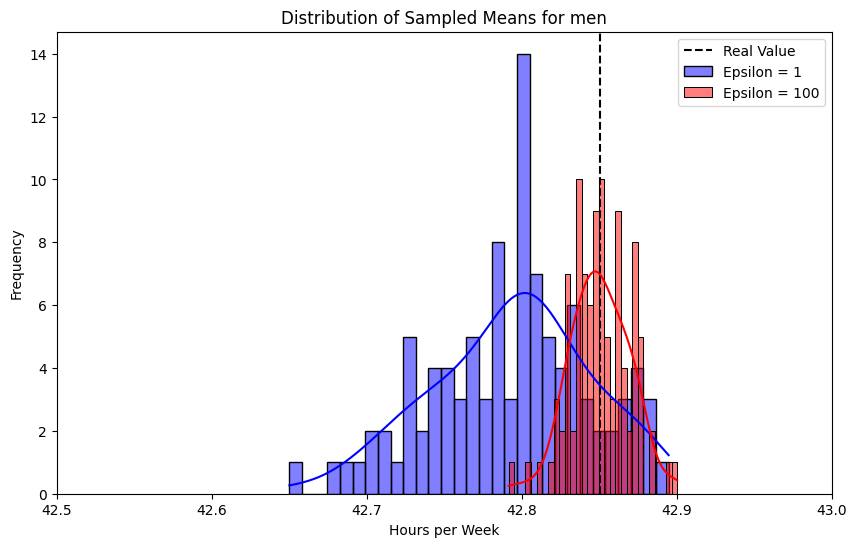

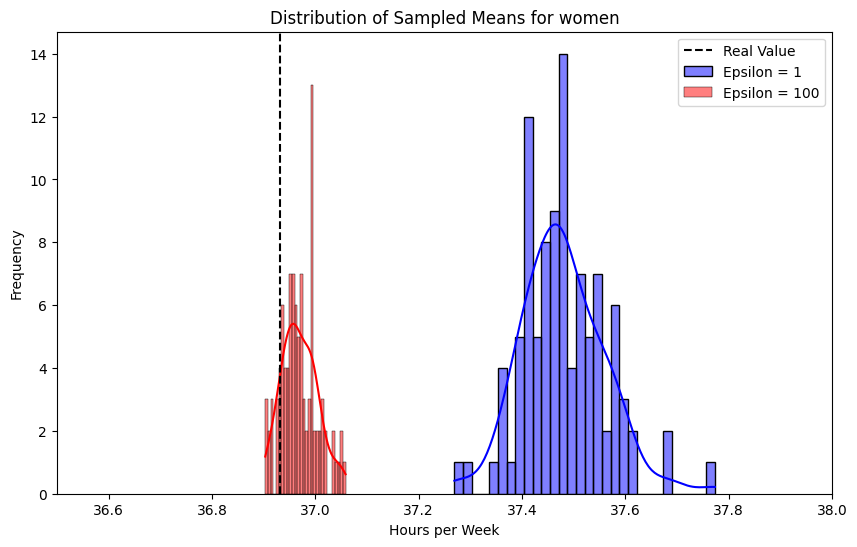

In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(sampled_means_df['Male'], kde=True, label='Epsilon = 1', color='blue', bins=30)
sns.histplot(sampled_means_100_df['Male'], kde=True, label='Epsilon = 100', color='red', bins=30)
plt.axvline(x=42.850687, color='black', linestyle='--', label='Real Value')
plt.title('Distribution of Sampled Means for men')
plt.xlabel('Hours per Week')
plt.ylabel('Frequency')
plt.xlim(42.5, 43)
plt.legend()
plt.savefig('distribution_men.pdf')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(sampled_means_df['Female'], kde=True, label='Epsilon = 1', color='blue', bins=30)
sns.histplot(sampled_means_100_df['Female'], kde=True, label='Epsilon = 100', color='red', bins=30)
plt.axvline(x=36.932222, color='black', linestyle='--', label='Real Value')
plt.title('Distribution of Sampled Means for women')
plt.xlabel('Hours per Week')
plt.ylabel('Frequency')
plt.xlim(36.5, 38)
plt.legend()
plt.savefig('distribution_women.pdf')
plt.show()

## Question 2: Are women and men working the same amount of time per week for each marital status and age range ?

In [78]:
adult_q2 = adult.drop(columns=['fnlwgt', 'occupation', 'education-num', 'capital-gain', 'capital-loss', 'education', 'race', 'relationship', 'native-country', 'income', 'workclass'])

bins = [0, 19, 29, 39, 49, 59, np.inf]
labels = ['0-19', '20-29', '30-39', '40-49', '50-59', '60+']
adult_q2['age_range'] = pd.cut(adult_q2['age'], bins=bins, labels=labels, right=False)
adult_q2.drop(columns=['age'], inplace=True)

In [79]:
synth_1_q2 = sn.Synthesizer.create('mst', epsilon=1.0, verbose=True)
synth_1_q2.fit(adult_q2)

Fitting with 7896 dimensions
Getting cliques
Estimating marginals


In [80]:
synth_100_q2 = sn.Synthesizer.create('mst', epsilon=100.0, verbose=True)
synth_100_q2.fit(adult_q2)

Fitting with 7896 dimensions
Getting cliques
Estimating marginals


In [84]:
adult['age_range'] = pd.cut(adult['age'], bins=bins, labels=labels, right=False)

/tmp/ipykernel_285328/3093607424.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_hours_per_week_by_gender_marital_age = adult.groupby(['gender', 'marital-status', 'age_range'])['hours-per-week'].mean()
/tmp/ipykernel_285328/3093607424.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='age_range', y='hours-per-week', hue='gender', data=mean_hours_per_week_by_gender_marital_age_bis, ci=None)


gender  marital-status  age_range
Female  Divorced        0-19               NaN
                        20-29        38.514286
                        30-39        40.110949
                        40-49        40.602139
                        50-59        40.217877
                                       ...    
Male    Widowed         20-29        40.000000
                        30-39        35.000000
                        40-49        39.705882
                        50-59        43.116279
                        60+          34.273973
Name: hours-per-week, Length: 84, dtype: float64


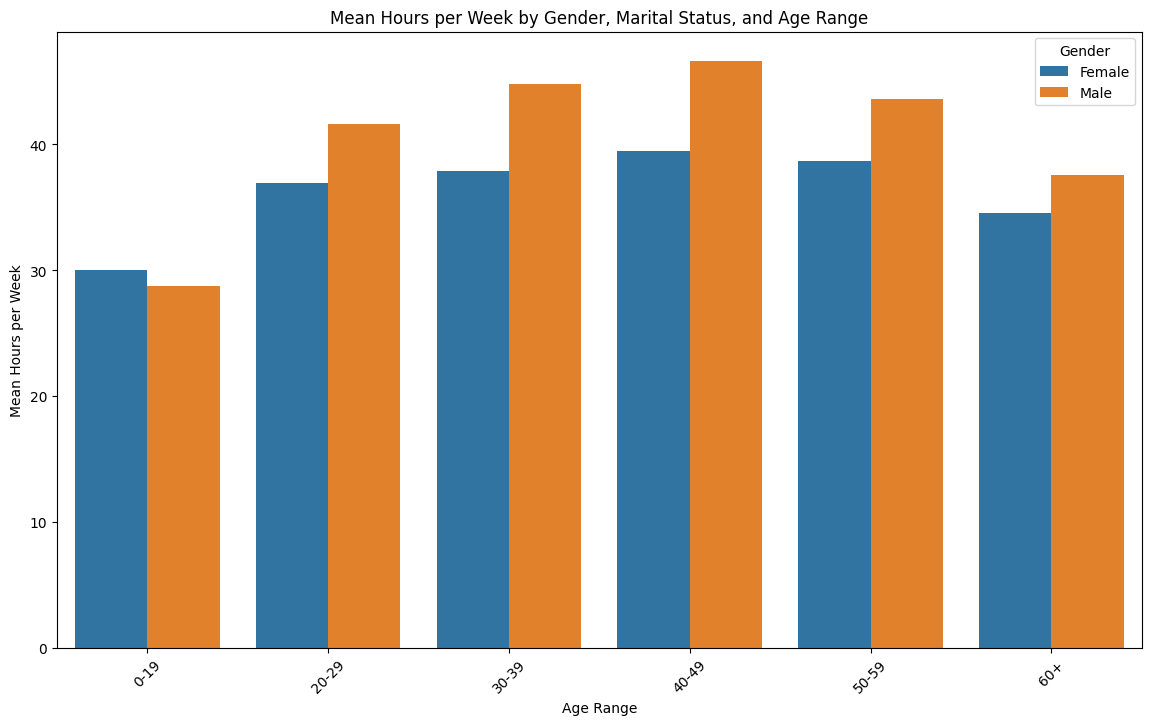

In [86]:
mean_hours_per_week_by_gender_marital_age = adult.groupby(['gender', 'marital-status', 'age_range'])['hours-per-week'].mean()
print(mean_hours_per_week_by_gender_marital_age)

In [90]:
num_samples = 100
sampled_means_q2 = []

for _ in range(num_samples):
    sampled_q2 = synth_1_q2.sample(10000)
    mean_hours_q2 = sampled_q2.groupby(['gender', 'marital-status', 'age_range'])['hours-per-week'].mean()
    sampled_means_q2.append(mean_hours_q2)

sampled_means_q2_df = pd.DataFrame(sampled_means_q2)

gender  marital-status         age_range
Female  Divorced               20-29        38.225489
                               30-39        43.269267
                               40-49        43.428582
                               50-59        42.844049
                               60+          37.938436
                                              ...    
        Married-civ-spouse     0-19         33.204545
        Separated              0-19         29.928571
        Widowed                0-19         18.000000
Male    Married-AF-spouse      20-29        40.000000
        Married-spouse-absent  0-19         30.000000
Length: 71, dtype: float64


In [92]:
mean_hours_per_week_by_gender_marital_age_sampled_1 = sampled_means_q2_df.mean()
print(mean_hours_per_week_by_gender_marital_age_sampled_1.to_markdown())

|                                              |       0 |
|:---------------------------------------------|--------:|
| ('Female', 'Divorced', '20-29')              | 38.2255 |
| ('Female', 'Divorced', '30-39')              | 43.2693 |
| ('Female', 'Divorced', '40-49')              | 43.4286 |
| ('Female', 'Divorced', '50-59')              | 42.844  |
| ('Female', 'Divorced', '60+')                | 37.9384 |
| ('Female', 'Married-AF-spouse', '20-29')     | 36.1667 |
| ('Female', 'Married-AF-spouse', '30-39')     | 43.8913 |
| ('Female', 'Married-civ-spouse', '20-29')    | 38.5275 |
| ('Female', 'Married-civ-spouse', '30-39')    | 43.2374 |
| ('Female', 'Married-civ-spouse', '40-49')    | 43.4014 |
| ('Female', 'Married-civ-spouse', '50-59')    | 42.8602 |
| ('Female', 'Married-civ-spouse', '60+')      | 37.4744 |
| ('Female', 'Married-spouse-absent', '20-29') | 38.2602 |
| ('Female', 'Married-spouse-absent', '30-39') | 43.7594 |
| ('Female', 'Married-spouse-absent', '40-49') | 43.2696

In [82]:
num_samples = 100
sampled_means_q2_100 = []

for _ in range(num_samples):
    sampled_q2_100 = synth_100_q2.sample(10000)
    mean_hours_q2 = sampled_q2_100.groupby(['gender', 'marital-status', 'age_range'])['hours-per-week'].mean()
    sampled_means_q2_100.append(mean_hours_q2)

sampled_means_q2_100_df = pd.DataFrame(sampled_means_q2_100)

mean_hours_per_week_by_gender_marital_age_sampled_100 = sampled_means_q2_100_df.mean()
print(mean_hours_per_week_by_gender_marital_age_sampled_100)

gender  marital-status         age_range
Female  Divorced               20-29        37.843232
                               30-39        43.429610
                               40-49        43.336941
                               50-59        42.839017
                               60+          36.808831
                                              ...    
Male    Married-AF-spouse      0-19         48.000000
Female  Married-spouse-absent  0-19         21.842105
Male    Separated              0-19         26.444444
Female  Married-AF-spouse      0-19         30.000000
Male    Widowed                0-19         22.000000
Length: 84, dtype: float64


In [113]:
q2_or = {}
q2_1 = {}
q2_100 = {}

In [114]:
# Identify common groups
common_groups = mean_hours_per_week_by_gender_marital_age.index.intersection(mean_hours_per_week_by_gender_marital_age_sampled_1.index).intersection(mean_hours_per_week_by_gender_marital_age_sampled_100.index)

# Calculate Euclidean distance for each group
distances_1 = {}
distances_100 = {}

for group in common_groups:
    if group[0] == 'Male':
        age_range, marital_status = group[2], group[1]
        female_group = ('Female', marital_status, age_range)
        if female_group in common_groups:
            x1, y1 = mean_hours_per_week_by_gender_marital_age[group], mean_hours_per_week_by_gender_marital_age[female_group]
            x2, y2 = mean_hours_per_week_by_gender_marital_age_sampled_1[group], mean_hours_per_week_by_gender_marital_age_sampled_1[female_group]
            x3, y3 = mean_hours_per_week_by_gender_marital_age_sampled_100[group], mean_hours_per_week_by_gender_marital_age_sampled_100[female_group]

            q2_or[group[1:]] = {'Male': mean_hours_per_week_by_gender_marital_age[group], 'Female': mean_hours_per_week_by_gender_marital_age[female_group]}
            q2_1[group[1:]] = {'Male': mean_hours_per_week_by_gender_marital_age_sampled_1[group], 'Female': mean_hours_per_week_by_gender_marital_age_sampled_1[female_group]}
            q2_100[group[1:]] = {'Male': mean_hours_per_week_by_gender_marital_age_sampled_100[group], 'Female': mean_hours_per_week_by_gender_marital_age_sampled_100[female_group]}
            
            distances_1[(marital_status, age_range)] = euclidean_distance(x1, y1, x2, y2)
            distances_100[(marital_status, age_range)] = euclidean_distance(x1, y1, x3, y3)

for group in distances_1.keys():
    print(f"{group}: Epsilon = 1, {distances_1[group]}, Epsilon = 100, {distances_100[group]}")


('Divorced', '20-29'): Epsilon = 1, 5.115816728666808, Epsilon = 100, 5.112280961457736
('Divorced', '30-39'): Epsilon = 1, 4.593709670894527, Epsilon = 100, 4.592699661799867
('Divorced', '40-49'): Epsilon = 1, 3.3515613313054864, Epsilon = 100, 3.3519165068295678
('Divorced', '50-59'): Epsilon = 1, 4.146421921864281, Epsilon = 100, 4.144352616193313
('Divorced', '60+'): Epsilon = 1, 4.149963591348743, Epsilon = 100, 4.1586556278006395
('Married-AF-spouse', '20-29'): Epsilon = 1, 9.552850069191102, Epsilon = 100, 8.76361975799933
('Married-civ-spouse', '0-19'): Epsilon = 1, 3.282357947831901, Epsilon = 100, 1.8285656776943293
('Married-civ-spouse', '20-29'): Epsilon = 1, 6.083935256168192, Epsilon = 100, 6.080447774426763
('Married-civ-spouse', '30-39'): Epsilon = 1, 7.944487484824885, Epsilon = 100, 7.943664235264594
('Married-civ-spouse', '40-49'): Epsilon = 1, 7.514912206731569, Epsilon = 100, 7.516067359185967
('Married-civ-spouse', '50-59'): Epsilon = 1, 7.924537921415004, Epsilo

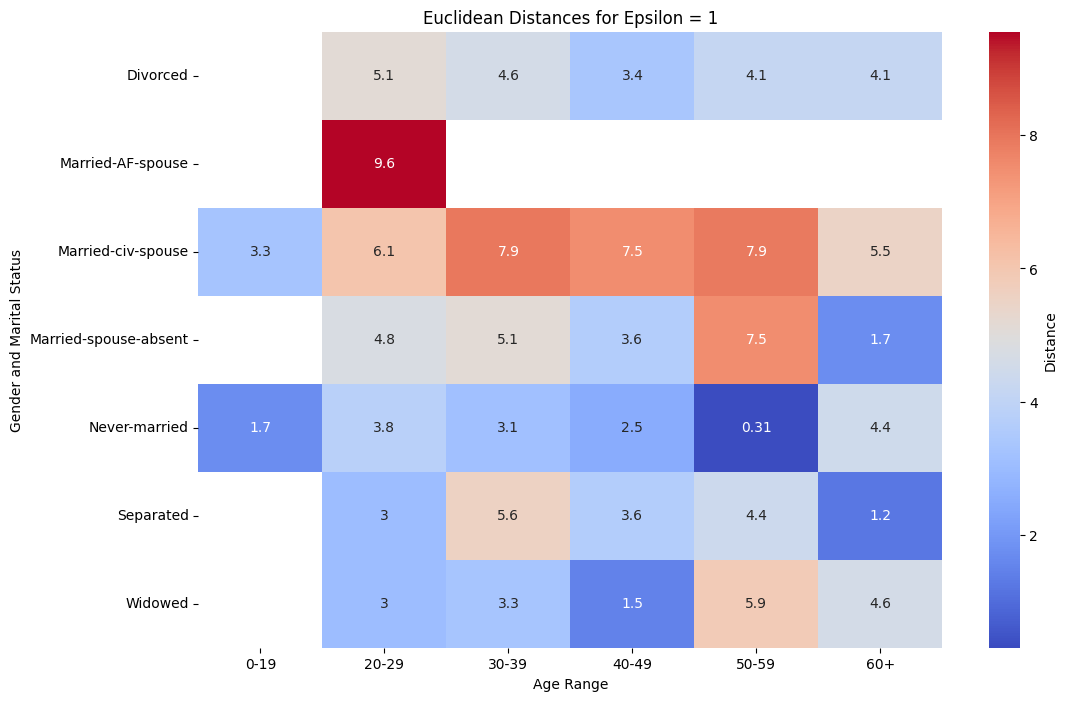

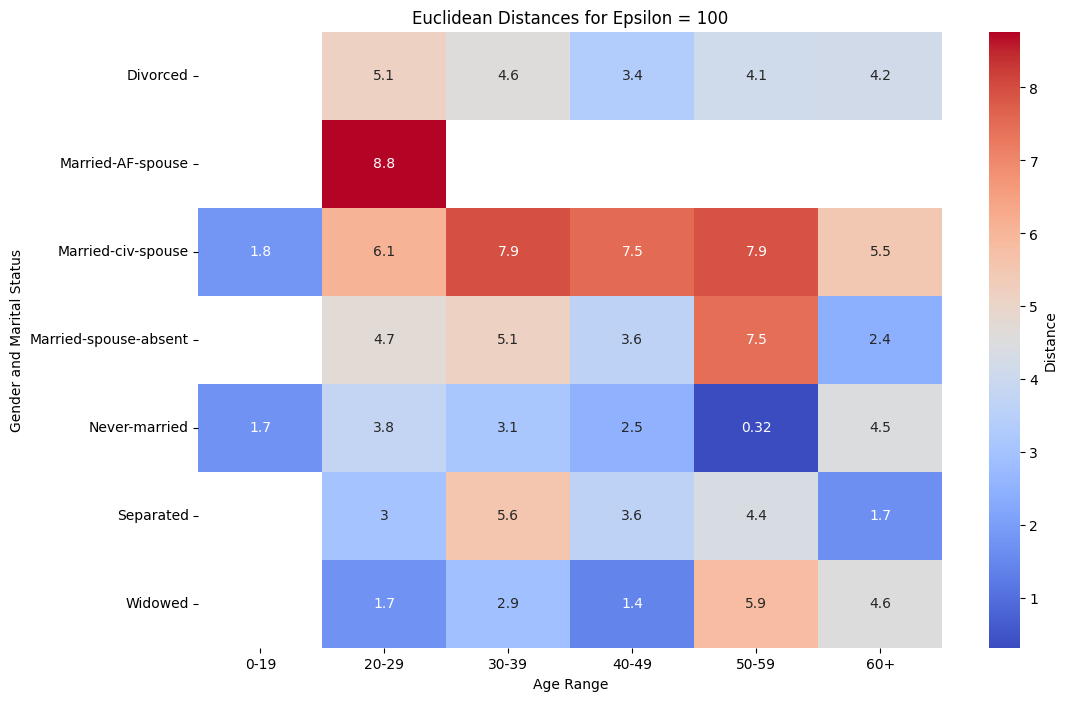

In [109]:
import seaborn as sns

import matplotlib.pyplot as plt

# Convert distances_1 and distances_100 to DataFrames for easier plotting
distances_1_df = pd.DataFrame.from_dict(distances_1, orient='index', columns=['Distance'])
distances_1_df.reset_index(inplace=True)
distances_1_df[['marital-status', 'age_range']] = pd.DataFrame(distances_1_df['index'].tolist(), index=distances_1_df.index)
distances_1_df.drop(columns=['index'], inplace=True)

distances_100_df = pd.DataFrame.from_dict(distances_100, orient='index', columns=['Distance'])
distances_100_df.reset_index(inplace=True)
distances_100_df[['marital-status', 'age_range']] = pd.DataFrame(distances_100_df['index'].tolist(), index=distances_100_df.index)
distances_100_df.drop(columns=['index'], inplace=True)

# Pivot the DataFrames to create matrices for heatmaps
heatmap_data_1 = distances_1_df.pivot_table(index=['marital-status'], columns='age_range', values='Distance')
heatmap_data_100 = distances_100_df.pivot_table(index=['marital-status'], columns='age_range', values='Distance')

# Plot heatmap for epsilon = 1
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_1, annot=True, cmap='coolwarm', cbar_kws={'label': 'Distance'})
plt.title('Euclidean Distances for Epsilon = 1')
plt.xlabel('Age Range')
plt.ylabel('Gender and Marital Status')
plt.show()

# Plot heatmap for epsilon = 100
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_100, annot=True, cmap='coolwarm', cbar_kws={'label': 'Distance'})
plt.title('Euclidean Distances for Epsilon = 100')
plt.xlabel('Age Range')
plt.ylabel('Gender and Marital Status')
plt.show()

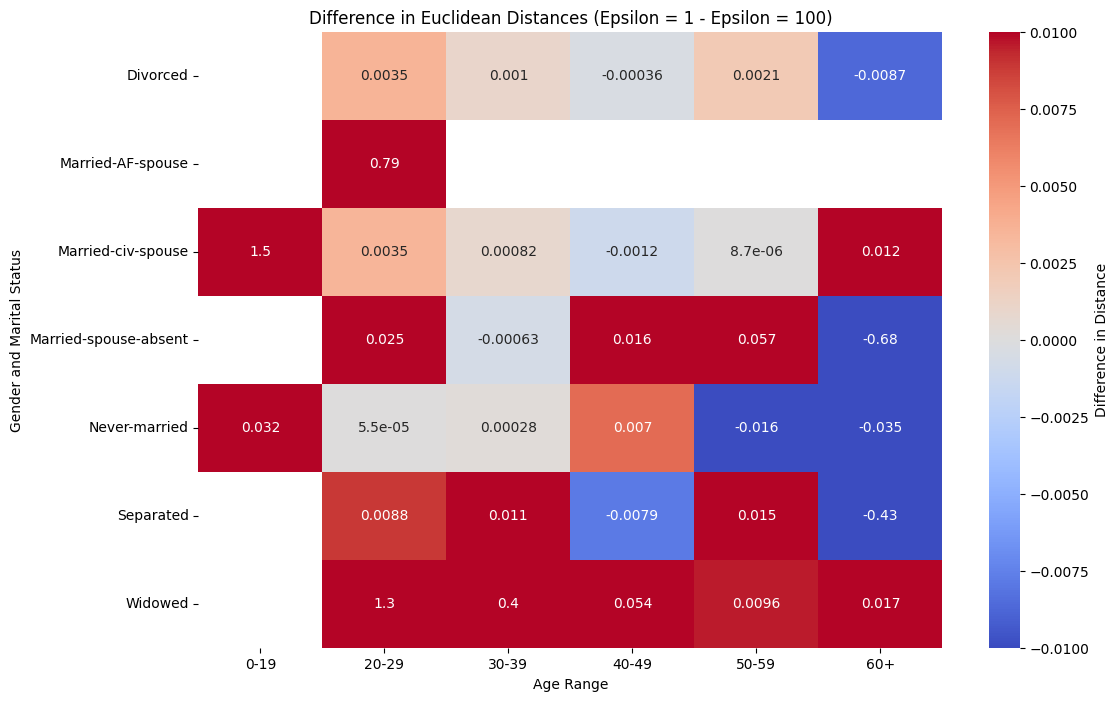

In [112]:
distances_diff = distances_1_df.set_index(['marital-status', 'age_range']) - distances_100_df.set_index(['marital-status', 'age_range'])

distances_diff.reset_index(inplace=True)

heatmap_data_diff = distances_diff.pivot_table(index=['marital-status'], columns='age_range', values='Distance')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_diff, annot=True, cmap='coolwarm', center=0, vmin=-0.01, vmax=0.01, cbar_kws={'label': 'Difference in Distance'})
plt.title('Difference in Euclidean Distances (Epsilon = 1 - Epsilon = 100)')
plt.xlabel('Age Range')
plt.ylabel('Gender and Marital Status')
plt.show()
